### Introduction
In this GBDX Notebook, we demonstrate the potential for using GBDX and Ecopia Building Footprints to assess the forest fire risk to buildings in Shaver Lake, CA by quantifying the tree coverage in the area around each building. 

If you haven't explored the [Ecopia Building Footprints and GBDX Notebook](https://notebooks.geobigdata.io/hub/notebooks/5a87205bbf151131f290fd51?tab=code), we recommend taking a look before reviewing this tutorial. It provides a more thorough introduction to some of the elements and ideas presented here.

### Getting Started
To get started, we need to install a few Python libraries and then import our modules to the Notebook.

In [1]:
print('Installing awscli...')
!pip install --upgrade awscli -qq
print('Installing PyHamcrest...')
!pip install PyHamcrest -qq
print('Installing cython...')
!pip install cython -qq
print('Installing sklearn...')
!pip install sklearn -qq
print('Installing folium...')
!pip install folium -qq
print('Installing tqdm...')
!pip install tqdm -qq
print('Installing nbfirerisk...')
!pip install git+https://github.com/GeoBigData/nbfirerisk.git -qq 
print("\nInstallation of modules is complete.")

Installing awscli...
Installing PyHamcrest...
Installing cython...
Installing sklearn...
Installing folium...
Installing tqdm...
Installing nbfirerisk...

Installation of modules is complete.


In [2]:
from gbdxtools import CatalogImage
import gbdxtools
gbdx = gbdxtools.Interface()
import gbdxtools
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tqdm
import time
from functools import partial
from shapely.geometry import box, shape
from skimage import segmentation, filters
import nbfirerisk
print("All modules loaded successfully")

All modules loaded successfully


### Get Imagery for an Area of Interest
We'll start our analysis by accessing an image for a popular recreational area in Fresno County, CA called Shaver Lake. The image we've specified below is an 8-band WorldView 2 image captured on August 11, 2017. When we plot the the visible bands of the image, you can see that this is a densely vegetated area with several buildings. Given the arid location and setting in the wildland-urban interface, this area might be at risk of forest fire.

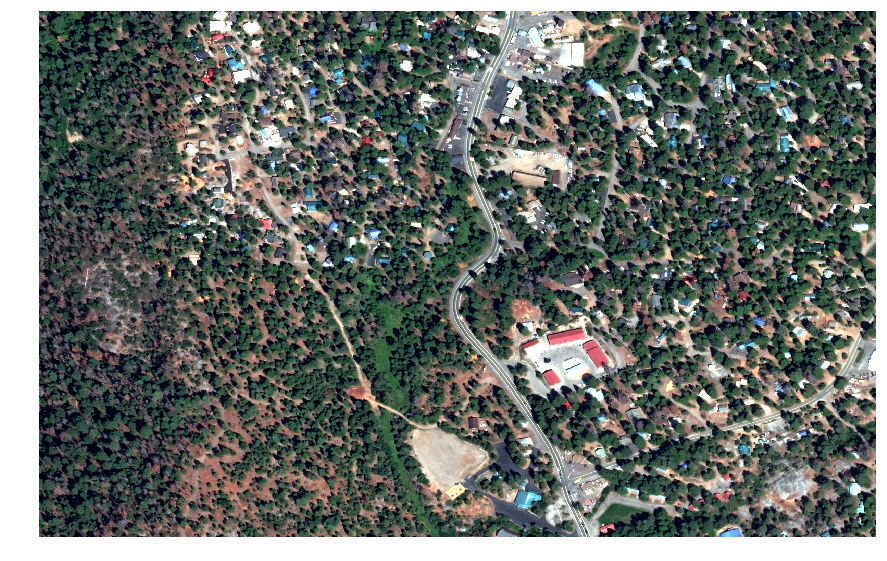

In [3]:
# Shaver Lake, CA
catalog_id = '103001006E28F900'
bbox = (-119.325, 37.10079727722707, -119.3144843598566, 37.107403037321205)

# Access the image as a CatalogImage
image = CatalogImage(catalog_id, band_type="MS", pansharpen=True, bbox=bbox)

# Plot it
image.plot(w=15, h=15)

# Turn off "Fetching Image..." statements
image._read = partial(image._read, quiet=True)

### Get Ecopia Building Fooprints
Next, we'll load in a small sample of Ecopia Building footprints covering this same area of interest. Once we have the buildings, we'll create an interactive map with the imagery as a backdrop so that we can explore the area in more detail.

In [4]:
# get footprints
shaver_lake_bldgs = nbfirerisk.ecopia_buildings_shaver_lake
geoms, buildings = nbfirerisk.from_geojson(shaver_lake_bldgs)
print(" There are {} Ecopia Building Footprints in this image.".format(len(buildings)))

# set the center location for the map
map_center = list(box(*bbox).centroid.coords)[0]
map_center_folium = [map_center[1], map_center[0]]  
# get the url for the imagery TMS
tms_url = nbfirerisk.TMS_103001006E28F900
# create the map
nbfirerisk.folium_map(nbfirerisk.to_geojson(buildings), 'Ecopia Building Footprints', location=map_center_folium, 
                       tiles=tms_url, attr='DigitalGlobe', zoom_start=16, map_zoom=16, height='100%', 
                       style_function=nbfirerisk.footprints_outline_styler,
                       tms=True, zoom_beyond_max=18, max_zoom=19)

 There are 263 Ecopia Building Footprints in this image.


### Defining the "Defensible Space"
In fire control, the concept of defensible space refers to the area surrounding a structure that, ideally, has been landscaped or maintained to reduce the amount of fuel, such as trees and other vegetation. In the next code cell, we will take a look at two specific zones around a single building: the "defensible area" (an area immediately surrounding the building, out to a distance of 9 m) and the "fuel reduction zone" (the area beyond the defensible area, extending a total of 30 m out from the building).

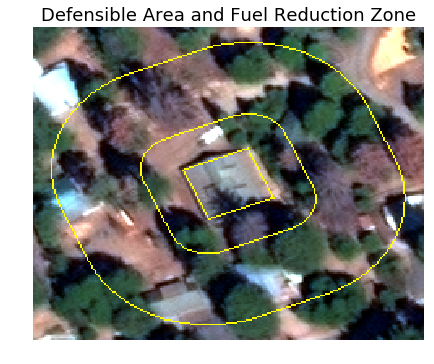

In [5]:
# create defensible area buffers around one building
building_id = 15 # CHANGE THIS ID TO SEE A DIFFERENT BUILDING

geom = buildings[building_id]['geometry']
# buffer the geometry by 35 m to grab a chip around it
chip_bounds = nbfirerisk.buffer_meters(geom, distance_m=35).bounds
chip = image.aoi(bbox=chip_bounds)
chip_rgb = chip.rgb()

# delineat the defensible area (9.1 m away from the building)
defensible_area_mask = nbfirerisk.geom_to_array(nbfirerisk.delineate_defensible_area(geom, area_radius_m=9), chip)

# delineate the fuel reduction zone (from 9.1 m to 30.5 m away from the building)
fuel_area_mask = nbfirerisk.geom_to_array(nbfirerisk.delineate_fuel_reduction_zone(geom, inner_radius_m=0, 
                                                                                   outer_radius_m=30), chip)

# add the area boundaries to the image
rgb_w_outlines = segmentation.mark_boundaries(chip_rgb, defensible_area_mask)
rgb_w_outlines = segmentation.mark_boundaries(rgb_w_outlines, fuel_area_mask)

# plot the results
sp = plt.figure(figsize=(7,7))
nbfirerisk.plot_array(rgb_w_outlines, (1,1,1), title="Defensible Area and Fuel Reduction Zone")
_ = plt.plot()

### Identifying Vegetation Using NDVI
In the image above, you can see that there are several trees in the both the defensible area and the fuel reduction zone. In order to quantify this, we'll try to identify the vegetation around the building using a simple NDVI (Normalized Difference Vegetation Index) mask. The resulting image shows the areas identified as vegetation outlined in yellow.

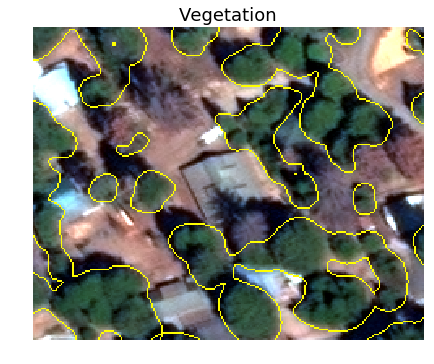

In [6]:
# calculate ndvi and use it to identify vegetation
ndvi = chip.ndvi(quiet=True)
#  clean up any nan values
ndvi[np.isnan(ndvi)] = 0
# create vegeation mask
veg = ndvi > filters.threshold_otsu(ndvi)

sp = plt.figure(figsize=(7,7))
nbfirerisk.plot_array(segmentation.mark_boundaries(chip_rgb, veg), (1,1,1), title="Vegetation")
_ = plt.plot()

### Identifying Trees Using Machine Learning
Looking closely at the image above, you'll notice that while the NDVI mask does an excellent job of identifying all of the live trees in the image, there are several dead trees that were not detected. For some applications, these omissions might not be of much concern, but in the case of fire preparedness, they are extremely important because they are a ready source of dry fuel. As a result, we'll need a more sophisticated approach to identifying the vegetation in this image. Specifically, we'll use a machine learning model that has been trained to identify trees in this area.

In the code cell below, we'll apply the machine learning model to detect trees and compare the results side-by-side with the results derived from the NDVI mask.

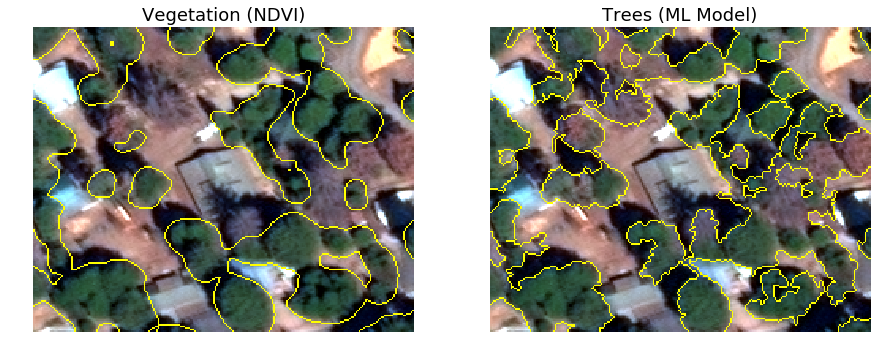

In [7]:
rf_model = nbfirerisk.get_model(nbfirerisk.tree_detection_model)
trees = nbfirerisk.find_all_trees(chip, rf_model)
# view results
sp = plt.figure(figsize=(15,15))
nbfirerisk.plot_array(segmentation.mark_boundaries(chip_rgb, veg), (1,2,1), title="Vegetation (NDVI)")
nbfirerisk.plot_array(segmentation.mark_boundaries(chip_rgb, trees), (1,2,2), title="Trees (ML Model)")
_ = plt.plot()

### Segmenting Dead and Live Trees
The images above show a dramatic improvement in the tree detection results using the machine learning model. Most of the dead trees are now captured within the extent of the yellow outlines. However, we can improve the results even further by combining the two approaches: we'll use the machine learning model to identify all of the trees, and then apply NDVI as a filter to segment stands of dead trees from stands of live trees.

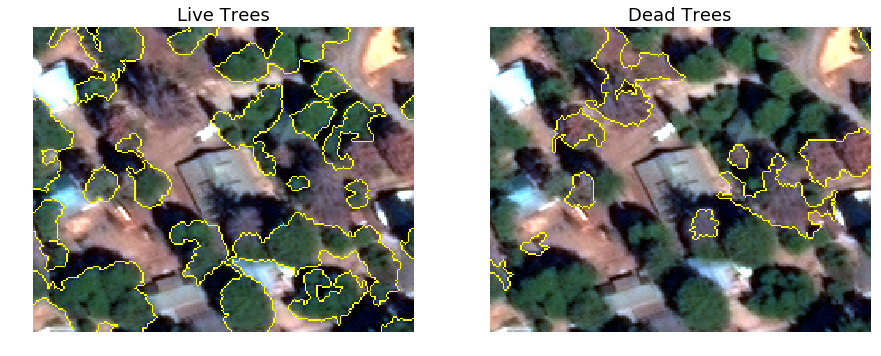

In [8]:
live_trees, dead_trees = nbfirerisk.segment_live_dead_trees(chip, rf_model, ndvi)
# view results
sp = plt.figure(figsize=(15,15))
nbfirerisk.plot_array(segmentation.mark_boundaries(chip_rgb, live_trees), (1,2,1), title="Live Trees")
nbfirerisk.plot_array(segmentation.mark_boundaries(chip_rgb, dead_trees), (1,2,2), title="Dead Trees")
_ = plt.plot()

### Assessing Tree Coverage in the Defensible Space
Now that we have an accurate representation of where both the live and dead trees are in the area around this building, we can do some analysis to assess the extent to which the Defensible Area and Fuel Reduction Zone of the building are covered by trees.

In [9]:
live_tree_polys, dead_tree_polys = nbfirerisk.segment_live_dead_trees(chip, rf_model, ndvi, return_geometries=True)
tree_coverage = nbfirerisk.assess_tree_coverage(geom, live_tree_polys, dead_tree_polys)
print("Defensible Area (<9.1m from building)")
print ("\t% Tree Coverage:\t{defensible_area_pct_all_trees}%".format(**tree_coverage))
print ("\t\t% Live Trees:\t{defensible_area_pct_live_trees}%".format(**tree_coverage))
print ("\t\t% Dead Trees:\t{defensible_area_pct_dead_trees}%".format(**tree_coverage))
print("\nFuel Reduction Zone (9.1 - 30m)")
print ("\t% Tree Coverage:\t{fuel_area_pct_all_trees}%".format(**tree_coverage))
print ("\t\t% Live Trees:\t{fuel_area_pct_live_trees}%".format(**tree_coverage))
print ("\t\t% Dead Trees:\t{fuel_area_pct_dead_trees}%".format(**tree_coverage))

Defensible Area (<9.1m from building)
	% Tree Coverage:	29.2%
		% Live Trees:	20.3%
		% Dead Trees:	8.9%

Fuel Reduction Zone (9.1 - 30m)
	% Tree Coverage:	44.1%
		% Live Trees:	28.8%
		% Dead Trees:	15.3%


### Analyzing All Buildings in the Area of Interest
Using the methods we've developed for this one building, we can scale out to assess all buildings in the area of interest in just a matter of minutes. For each building, we'll determine the same set of tree coverage statistics.

In [10]:
# calculate ndvi and use it to identify vegetation
full_ndvi = image.ndvi(quiet=True)
#  clean up any nan values
full_ndvi[np.isnan(full_ndvi)] = 0

print("Segmenting trees for full image...")
full_live_trees, full_dead_trees = nbfirerisk.segment_live_dead_trees(image, rf_model, full_ndvi, 
                                                                      return_geometries=True)
print("Segmentation completed succesfully.")

Segmenting trees for full image...
Segmentation completed succesfully.


In [11]:
print("Assessing tree coverage for all buildings...")
# pause for a beat so that print statement show up in the right place
time.sleep(1)
# run the coverage calculations
for building in tqdm.tqdm(buildings):
    tree_coverage = nbfirerisk.assess_tree_coverage(building['geometry'], full_live_trees, full_dead_trees)
    building['properties'].update(tree_coverage)
# pause again so that print statement show up in the right place
time.sleep(1)
print("Tree coverage assessment completed succesfully.")

Assessing tree coverage for all buildings...


100%|██████████| 263/263 [02:02<00:00,  1.89it/s]


Tree coverage assessment completed succesfully.


### Identifying Buildings with "High" Fire risk
For each building, we now have a number of statistics about the tree coverage in the Defensible Area and the Fuel Reduction Zone. We'll complete our analysis by using these data to assess which buildings may be of particularly high risk in the case of a forest fire. We'll use some very simple heuristics to make this risk assessment. Specifically, a building will be identified as "high risk" if any of the following conditions are true:
  1. Its Defensible Area has >25% tree coverage
  2. Its Fuel Reduction Zone has >50% trees coverage
  3. Either its Defensible Area or its Fuel Reduction Zone has >10% dead trees coverage

Please note that these heuristics are not based in any actuarial model; they are just meant to illustrate the potential for using the extracted data to draw insights about the relative fire risk of buildings in the region.

In the resulting map, the "high risk" buildings that we've identified will appear with red outlines, while all other buildings will appear with green outlines.

In [12]:
# identify "high risk" buildings based on some simple heuristics
for building in buildings:
    if (building['properties']['defensible_area_pct_all_trees'] > 25 or
        building['properties']['fuel_area_pct_all_trees'] > 50 or
        building['properties']['defensible_area_pct_dead_trees'] > 10 or 
        building['properties']['fuel_area_pct_dead_trees'] > 10):
        building['properties']['high_risk'] = 'True'
    else:
        building['properties']['high_risk'] = 'False'
# map the results
properties = ['high_risk', 'defensible_area_pct_all_trees', 'defensible_area_pct_live_trees', 
              'defensible_area_pct_dead_trees', 'fuel_area_pct_all_trees', 
              'fuel_area_pct_live_trees', 'fuel_area_pct_dead_trees'] 
aliases = ['High Fire Risk', 'Def. Area % Trees (All)', 'Def. Area % Trees (Live)',
           'Def. Area % Trees (Dead)', 'Fuel Area % Trees (All)',
           'Fuel Area % Trees (Live)', 'Fuel Area % Trees (Dead)']
m = nbfirerisk.folium_map(nbfirerisk.to_geojson(buildings), 'Ecopia Building Footprints', location=map_center_folium,
                      tiles=tms_url, attr='DigitalGlobe', zoom_start=16, map_zoom=16, height='100%', 
                      style_function=nbfirerisk.footprints_risk_styler,
                      tms=True, zoom_beyond_max=18, max_zoom=19, 
                      tooltip_props=properties, tooltip_aliases=aliases)
m